## Feed Forward Network 
Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In this notebook, we are focusing on creating a shallow consiting of 2 linear layers on which Relu and batch normalization is applied. 

After this we move forward to train our model on a deep network consisting of 4 linear layers on which Relu and Batch Normalization is applied. 

In [1]:
# Here we make all the imports
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm, trange
import seaborn as sns

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pytorchtools

# Model Definitions

Below we have defined our shallow and Deep layers. We tried different models by increasing and decreasing the number of linear layers. We also tried different dropout values. The following experiment showed us that the best model is the a deep structiure with 4 layers. Moving beyond this we start overfitting 

In [4]:
input_dim = 2815
hidden_1 = 1000
hidden_2 = 256
output_dim = 2

class BNShallowNet(nn.Module):
    def __init__(self):
        super(BNShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        #self.fc5 = nn.Linear(32, 2)
        #self.fc6 = nn.Linear(16, 2)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        # x = self.bn4(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc6(x)
        output = F.log_softmax(x, dim=1)
        return output



The below function is used to divide the datasets into small chunks 

In [5]:
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

This code is used to import the Concat Embeddings of Images and Text and to load the Json files.

In [19]:
concat_embeddings = pd.read_csv("/content/drive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [7]:
train_data = pd.read_json("/content/drive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
batch_size = 32
chunked_data = split_dataframe(train_data, batch_size)

In [8]:
preds_train=[]
target_train =[]
preds_val=[]
target_val=[]

Code for training and validating the models 

In [9]:
def train(args, model, device, chunked_data, optimizer,criterion, concat_embeddings):
    model.train()

    for e in range(args['epochs']): 
      preds_train=[]
      target_train =[]
      avg_loss = 0.
      correct = 0
      total = 0
      for batch_idx, (data) in enumerate(chunked_data):
          id = data.id
          
          target = torch.Tensor(data.label.tolist()).to(device)
          a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
          if(len(a)==0):
            continue
          data = torch.Tensor(a).to(device)
          optimizer.zero_grad()
          output = model(data)

          loss = criterion(output, target.type(torch.cuda.LongTensor))
          avg_loss += loss.item()
          
          loss.backward()
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          #print(predicted.cpu().numpy())
          #print(target.cpu().numpy())
          # r= confusion_matrix(target.cpu().numpy(), predicted.cpu().numpy())
          p = predicted.cpu().numpy()
          t = target.cpu().numpy()
          
          preds_train.extend(p)
          target_train.extend(t)
         

          correct += (predicted.cpu() == target.cpu()).sum()
          optimizer.step()
      #print(preds_train)
      avg_loss /= len(chunked_data)
      print("Epoch : " + str(e)  + "  loss : " + str(avg_loss))
      precision, recall, f1, _ = precision_recall_fscore_support(preds_train, target_train, average='binary')
      r= confusion_matrix(preds_train, target_train)
      print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
      print("confusion_matrix")
      print(r)

      roc_auc = roc_auc_score(preds_train, target_train)
      print("roc",roc_auc)
      accuracy = 100.00 * correct.numpy() / total
      print("Epoch : " + str(e)  + "  accuracy : " + str(accuracy))


In [10]:
def post_train(args, model, device, chunked_data,criterion, concat_embeddings):
    model.eval()

    avg_loss = 0.
    correct = 0
    total = 0
    preds_val=[]
    target_val=[]
    for batch_idx, (data) in enumerate(chunked_data):
        id = data.id
        target = torch.Tensor(data.label.tolist()).to(device)
        a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
        if(len(a)==0):
          continue
        data = torch.Tensor(a).to(device)
        output = model(data)
        #print(output.shape,target.shape)


        loss = criterion(output, target.type(torch.cuda.LongTensor))
        avg_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted.cpu() == target.cpu()).sum()
        p = predicted.cpu().numpy()
        t = target.cpu().numpy()
        preds_val.extend(p)
        target_val.extend(t)

    avg_loss /= len(chunked_data)
    precision, recall, f1, _ = precision_recall_fscore_support(preds_val, target_val, average='binary')
    precision1, recall1, thresholds = precision_recall_curve(preds_val, target_val)
    r= confusion_matrix(preds_val, target_val)
    accuracy = 100.00 * correct.numpy() / total
    fpr, tpr, _ = roc_curve(target_val, preds_val)

    print( "  accuracy : " + str(accuracy))
    print("  loss : " + str(avg_loss))
    print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
    print("confusion_matrix")
    print(r)
    roc_auc = roc_auc_score(preds_val, target_val)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)

    for i in range(r.shape[0]):
      for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
    
    print("roc",roc_auc)
    #plt.figure(1)

    #sns.heatmap(r,annot=True)
    plt.show()


    pyplot.plot(recall1, precision1, marker='.', label='Shallow_net')
    # axis labels
    print("Precison Vs Recall")
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.title('Precision Vs Recall', fontsize=20)
    # show the plot
    pyplot.show()

    print("ROC")

    # plt.plot([0, 1], [0, 1], 'k–')
    plt.plot(fpr, tpr, label='FNN_ROC(area = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()




# Shallow : Train

In [20]:
import json
model_shallow = BNShallowNet().to('cuda')
args = {'lr': 0.1, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_shallow.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_shallow, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6772210183728459
 precision :0.2673070553163299 recall :0.45696489241223104 f1 0.33730407523510975
confusion_matrix
[[4522 2212]
 [ 959  807]]
roc 0.5642412819649513
Epoch : 0  accuracy : 62.694117647058825
Epoch : 1  loss : 0.6591705383550852
 precision :0.2974494865849619 recall :0.4977827050997783 f1 0.37238233464648557
confusion_matrix
[[4575 2121]
 [ 906  898]]
roc 0.5905132163491724
Epoch : 1  accuracy : 64.38823529411765
Epoch : 2  loss : 0.6497453235762012
 precision :0.32427956276912884 recall :0.5246516613076099 f1 0.4008188331627431
confusion_matrix
[[4594 2040]
 [ 887  979]]
roc 0.6085724390348722
Epoch : 2  accuracy : 65.56470588235294
Epoch : 3  loss : 0.6301770650298524
 precision :0.35508446505465385 recall :0.5466598674145844 f1 0.43052208835341366
confusion_matrix
[[4592 1947]
 [ 889 1072]]
roc 0.6244539587875797
Epoch : 3  accuracy : 66.63529411764706
Epoch : 4  loss : 0.6214895105283511
 precision :0.34912222590261677 recall :0.5524109014675053 f

# Shallow : Validation

Running the validation loss and accuarcy on the concat embeddings of dev seen and dev unseen csv

  accuracy : 40.925925925925924
  loss : 1.096699925029979
 precision :0.845 recall :0.36980306345733044 f1 0.5144596651445967
confusion_matrix
[[ 52  31]
 [288 169]]
roc 0.49815454377685797


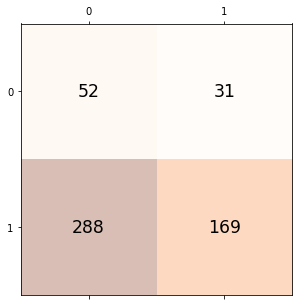

Precison Vs Recall


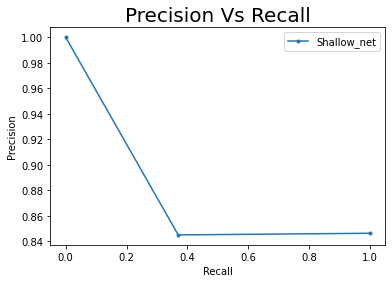

ROC


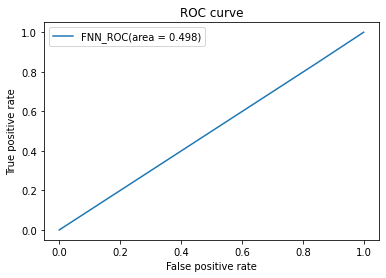

In [21]:

validation_paths = ["/content/drive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_dev_unseen.csv"]
concat_embeddings_validation = pd.concat( map(pd.read_csv, validation_paths), ignore_index=True)
concat_embeddings_validation.head()
concat_embeddings_validation.rename(columns={"0": "id"}, inplace=True)
batch_size = 32
val_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/dev_unseen.jsonl", lines=True)

val_data_unseen = val_data_unseen[val_data_unseen.id.isin(concat_embeddings_validation.id)]
chunked_data_validation = split_dataframe(val_data_unseen, batch_size)


args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Shallow : Test Unseen


  accuracy : 44.15
  loss : 1.1212614859853471
 precision :0.8733333333333333 recall :0.3905784138342278 f1 0.5397610218376597
confusion_matrix
[[ 228   95]
 [1022  655]]
roc 0.5482303833877021


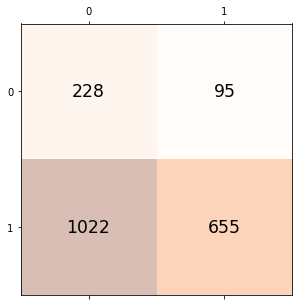

Precison Vs Recall


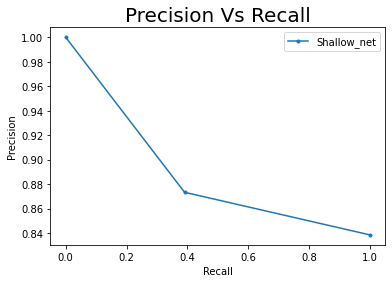

ROC


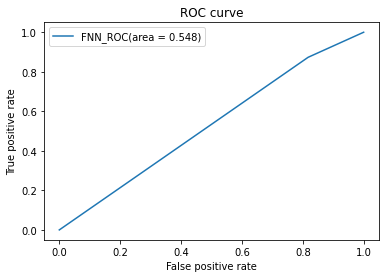

In [22]:
test_unseen_paths = ["/content/drive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_test_unseen.csv"]

concat_embeddings_test_unseen = pd.concat( map(pd.read_csv, test_unseen_paths), ignore_index=True)
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/test_unseen.jsonl", lines=True)

test_data_unseen = test_data_unseen[test_data_unseen.id.isin(concat_embeddings_test_unseen.id)]
chunked_data_test_unseen = split_dataframe(test_data_unseen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)

# Shallow: Test Seen

  accuracy : 49.3
  loss : 0.9234428983181715
 precision :0.8571428571428571 recall :0.49008168028004667 f1 0.623608017817372
confusion_matrix
[[ 73  70]
 [437 420]]
roc 0.5002855953847786


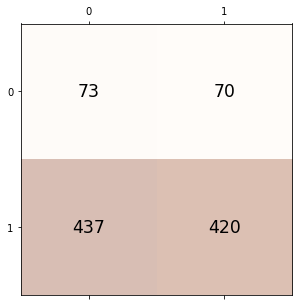

Precison Vs Recall


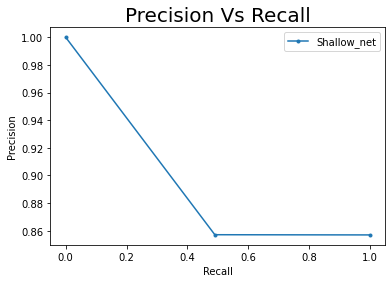

ROC


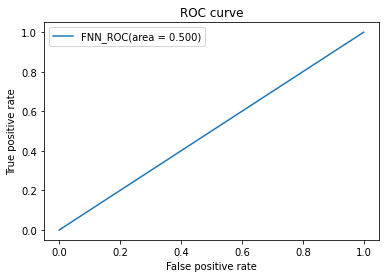

In [23]:
test_seen_paths = ["/content/drive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_test_seen.csv"]

concat_embeddings_test_seen = pd.concat( map(pd.read_csv, test_seen_paths), ignore_index=True)
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_seen = pd.read_json("/content/drive/MyDrive/522-project/test_seen.jsonl", lines=True)

test_data_seen = test_data_seen[test_data_seen.id.isin(concat_embeddings_test_seen.id)]
chunked_data_test_seen = split_dataframe(test_data_seen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model : Training

In [15]:
import json
model_deep = BNDeepNet().to('cuda')
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_deep.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_deep, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6853202970180297
 precision :0.2007287181185823 recall :0.390715667311412 f1 0.26520787746170676
confusion_matrix
[[4536 2413]
 [ 945  606]]
roc 0.5217357297558644
Epoch : 0  accuracy : 60.49411764705882
Epoch : 1  loss : 0.6449939821447644
 precision :0.06591586618085458 recall :0.44819819819819817 f1 0.1149292520935605
confusion_matrix
[[5236 2820]
 [ 245  199]]
roc 0.5490742728826145
Epoch : 1  accuracy : 63.94117647058823
Epoch : 2  loss : 0.6419396680548675
 precision :0.04968532626697582 recall :0.46875 f1 0.0898472596585804
confusion_matrix
[[5311 2869]
 [ 170  150]]
roc 0.5590082518337408
Epoch : 2  accuracy : 64.24705882352941
Epoch : 3  loss : 0.6380450830871898
 precision :0.040079496522027164 recall :0.4763779527559055 f1 0.07393828292086771
confusion_matrix
[[5348 2898]
 [ 133  121]]
roc 0.562467414408513
Epoch : 3  accuracy : 64.34117647058824
Epoch : 4  loss : 0.6350359827055967
 precision :0.05697250745279894 recall :0.4985507246376812 f1 0.102259215

# Deep Model: Validation

  accuracy : 56.111111111111114
  loss : 0.6849068403244019
 precision :0.265 recall :0.3706293706293706 f1 0.30903790087463556
confusion_matrix
[[250 147]
 [ 90  53]]
roc 0.5001761462718641


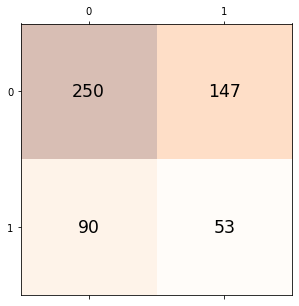

Precison Vs Recall


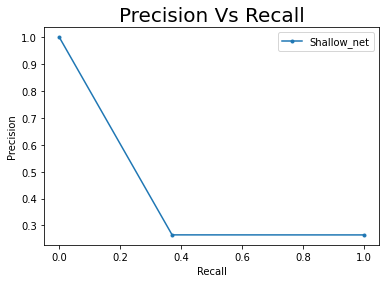

ROC


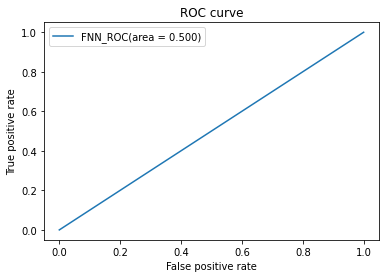

In [16]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Deep Model: Test Seen 

  accuracy : 52.4
  loss : 0.7145460546016693
 precision :0.28775510204081634 recall :0.5261194029850746 f1 0.37203166226912926
confusion_matrix
[[383 349]
 [127 141]]
roc 0.5246717233504609


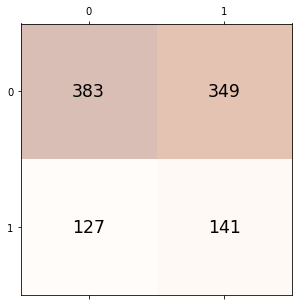

Precison Vs Recall


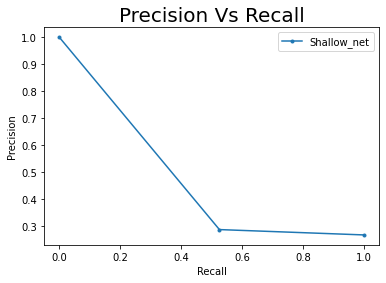

ROC


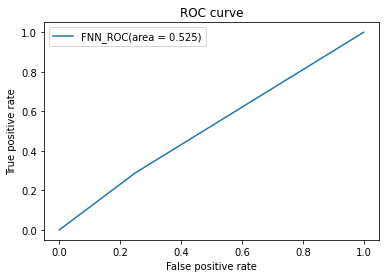

In [17]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model: Test UnSeen

  accuracy : 58.15
  loss : 0.6705367271862333
 precision :0.32 recall :0.42328042328042326 f1 0.36446469248291574
confusion_matrix
[[923 510]
 [327 240]]
roc 0.5336918515564713


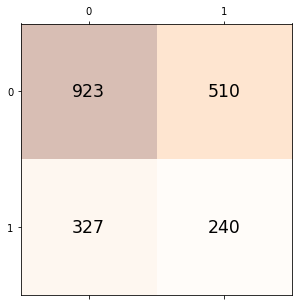

Precison Vs Recall


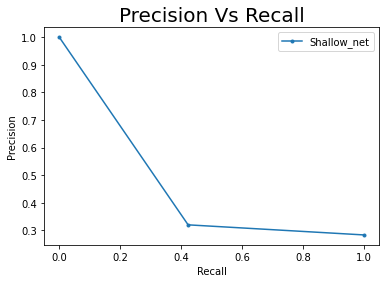

ROC


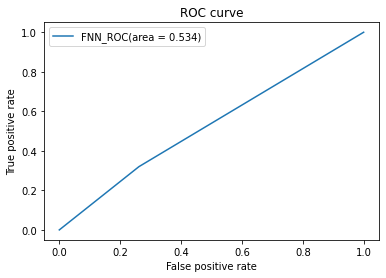

In [18]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)